# Influencers in Social Networks
Albert Byun, Hussein Danish, Nick Hamlin, Vincent Chio, Walter Erquinigo Pezo

## Background 

See https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network/data for more info on the problem setup. An example solution is available at https://gist.github.com/fhuszar/5372873

In [225]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import hashlib

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GMM
from sklearn.linear_model import LogisticRegression

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

## Data Ingest

In [2]:
def load_train_data():
    with open('data/train.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        data = np.loadtxt(f, delimiter=',')
        X, Y = data[:,1:], data[:,:1]
        return features, X, Y.flatten()

def load_test_data():
    with open('data/test.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        return np.loadtxt(f, delimiter=',')

def prepare_train_data(X, Y, test_size=1.0/6):
    np.random.seed(0)
    
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, Y = X[shuffle], Y[shuffle]
    break_point = int(X.shape[0] * (1 - test_size))
    return X[:break_point], Y[:break_point], X[break_point:], Y[break_point:]
    
features, X, Y = load_train_data()
train_data, train_labels, dev_data, dev_labels = prepare_train_data(X, Y)
test_data = load_test_data()

print train_data.shape, dev_data.shape, test_data.shape

(4583, 22) (917, 22) (5952, 22)


## Export Results for Kaggle Submission

In [3]:
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')

In [4]:
def log_features(x):
    return np.log(1+x)

def standardize_features(x):
    return StandardScaler().fit_transform(x)

def pairwise_diff(data):
    return data[:,0:11] - data[:,11:]

def pairwise_transform(data):
    return log_features(data[:,0:11]) - log_features(data[:,11:])

def pairwise_features_transform(features):
    return ['d_'+feature[2:] for feature in features[:11]]

train_data_transformed = pairwise_transform(train_data)
dev_data_transformed = pairwise_transform(dev_data)
features_transformed = pairwise_features_transform(features)
X_transformed = pairwise_transform(X)
test_data_transformed = pairwise_transform(test_data)

# Examine data

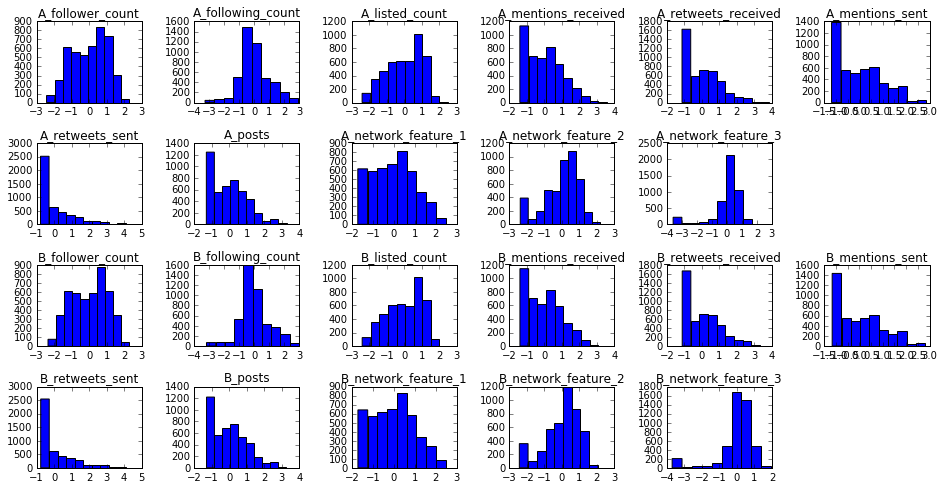

In [8]:
plt.figure(figsize=(16, 8))
for i, feature in enumerate(features):
    plt.subplot(4,6,i+1 if i < 11 else i+2)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.hist(standardize_features(log_features(train_data[:,i])))
    plt.title(feature)

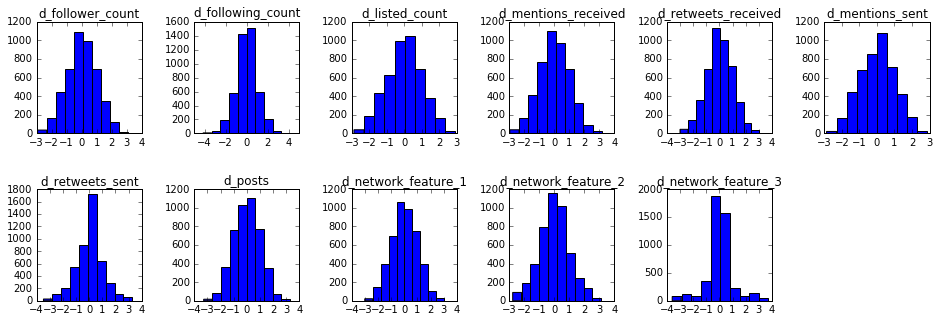

In [7]:
plt.figure(figsize=(16, 5))
for i, feature in enumerate(features_transformed):
    plt.subplot(2,6,i+1)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    plt.hist(standardize_features(train_data_transformed[:,i]))
    plt.title(feature)

In [5]:
def train_gridsearch_classifier(classifier, param, train_data, train_labels):
    """Use GridSearchCV to find the best estimator using the specified parameters.
    
    f1_weighted is used as the scoring metric.
    
    @param classfier: The base classifier.
    @param param: The parameters to be evaluated.
    @param train_data: The training data.
    @param train_labels: The training labels.
    @return The Grid classifier trained with the best estimator.
    """
    grid_cls = GridSearchCV(classifier, param, scoring='accuracy')
    grid_cls.fit(train_data, train_labels)
    return grid_cls

def report_score(grid_cls, dev_data, dev_labels):
    """Report the result from  GridSearchCV.
    
    Example:
    ---------------------------------------------------------------
    Parameters scores:
    mean: 0.40479, std: 0.01913, params: {'n_neighbors': 1}
    mean: 0.40851, std: 0.02859, params: {'n_neighbors': 5}
    mean: 0.41284, std: 0.02365, params: {'n_neighbors': 10}
    mean: 0.42409, std: 0.01053, params: {'n_neighbors': 50}

    Best param: {'n_neighbors': 50}, f1-score: 0.418
    ---------------------------------------------------------------
    
    @param grid_cls: A trained classifier using GridSearchCV.
    @param dev_data: The development data.
    @param dev_labels: The development labels.
    """
    pred_labels = grid_cls.predict(dev_data)
    print "Parameters scores:"
    for grid_score in grid_cls.grid_scores_:
        print grid_score
    print "\n"
    print "Best param: %(best)s, accuracy: %(score)s" % {
        'best': grid_cls.best_params_, 'score': round(metrics.accuracy_score(dev_labels, pred_labels), 3)
    }

# Dimension Reduction

In [7]:
def PCA_transform(data, dim):
    pca = PCA(n_components=dim)
    return pca.fit_transform(data)

## PCA

In [8]:
pca = PCA()
pca.fit(train_data_transformed)

for k in range(0,10):
    print "%(fraction)s%% of total variance is explained by the first %(k)s component" % {
        'fraction': round(sum(pca.explained_variance_ratio_[:(k+1)])*100, 2), 'k': k+1
    }

70.41% of total variance is explained by the first 1 component
83.14% of total variance is explained by the first 2 component
90.25% of total variance is explained by the first 3 component
94.96% of total variance is explained by the first 4 component
97.05% of total variance is explained by the first 5 component
98.32% of total variance is explained by the first 6 component
98.92% of total variance is explained by the first 7 component
99.36% of total variance is explained by the first 8 component
99.71% of total variance is explained by the first 9 component
99.92% of total variance is explained by the first 10 component


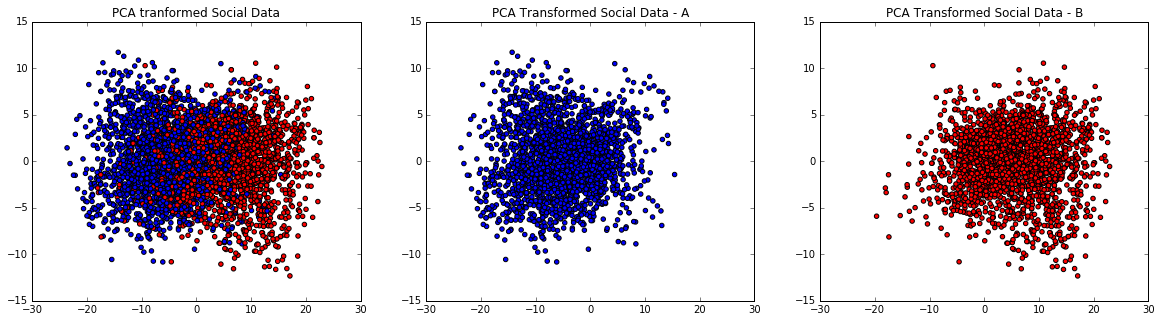

In [143]:
two_dim_train_data_transformed = PCA_transform(train_data_transformed, 2)
two_dim_dev_data_transformed = PCA_transform(dev_data_transformed, 2)
A_i = train_labels == 1
B_i = train_labels == 0

def plot_pca_transformed_data():
    plt.figure(figsize=(20, 5))

    p = plt.subplot(1, 3, 1)
    p.scatter(two_dim_train_data_transformed[:, 0], two_dim_train_data_transformed[:, 1],
              c=train_labels, cmap=ListedColormap(['red', 'blue']))
    plt.title("PCA tranformed Social Data")
    plt.xlim((-30, 30))
    plt.ylim((-15, 15))

    p = plt.subplot(1, 3, 2)
    p.scatter(two_dim_train_data_transformed[A_i][:, 0], two_dim_train_data_transformed[A_i][:, 1],
              c=train_labels[A_i], cmap=ListedColormap(['blue']))
    plt.title("PCA Transformed Social Data - A")
    plt.xlim((-30, 30))
    plt.ylim((-15, 15))

    p = plt.subplot(1, 3, 3)
    p.scatter(two_dim_train_data_transformed[B_i][:, 0], two_dim_train_data_transformed[B_i][:, 1],
              c=train_labels[B_i], cmap=ListedColormap(['red']))
    plt.title("PCA Transformed Social Data - B")
    plt.xlim((-30, 30))
    plt.ylim((-15, 15))

plot_pca_transformed_data()

In [141]:
COVARIANCE_TYPES = ['spherical', 'diag', 'tied', 'full']

def gmm_accuracy(gmm_n, cov_type, a_train_data, b_train_data, test_data, test_labels):
    gmm_a = GMM(n_components = gmm_n, covariance_type=cov_type)
    gmm_a.fit(a_train_data)
    gmm_b = GMM(n_components = gmm_n, covariance_type=cov_type)
    gmm_b.fit(b_train_data)
    a_prob = gmm_a.score(test_data)
    b_prob = gmm_b.score(test_data)
    pred_labels = []
    for i in range(0, len(a_prob)):
        if b_prob[i] > a_prob[i]:
            pred_labels.append(0)
        else:
            pred_labels.append(1)
    return metrics.accuracy_score(test_labels, pred_labels)

def calculate_param_size(pca_n, gmm_n, cov_type, class_n):
    'spherical', 'diag', 'tied', 'full'
    if cov_type == 'spherical':
        return ((pca_n+1)*gmm_n)*class_n
    elif cov_type == 'diag':
        return ((pca_n+pca_n)*gmm_n)*class_n
    elif cov_type == 'tied':
        return (pca_n*gmm_n + pca_n*(pca_n+1)/2)*class_n
    elif cov_type == 'full':
        return ((pca_n+pca_n*(pca_n+1)/2)*gmm_n)*class_n
    else:
        return 0

def find_best_pca_gmm_model():
    PARAM_LIMIT = 30
    best_accuracy = 0
    best_param = (0, 0, 'spherical') # (pca_n, gmm_n, cov_type)
    for cov_type in COVARIANCE_TYPES:
        pca_n = 2
        gmm_n = 1
        param_size = 0
        while True:
            param_size = calculate_param_size(pca_n, gmm_n, cov_type, 2)
            if param_size > PARAM_LIMIT or pca_n > 11:
                break
            while True:
                pca_transformed_train_data = PCA_transform(train_data_transformed, pca_n)
                pca_transformed_dev_data = PCA_transform(dev_data_transformed, pca_n)
                accuracy = gmm_accuracy(gmm_n, cov_type, pca_transformed_train_data[A_i],
                                        pca_transformed_train_data[B_i], 
                                        pca_transformed_dev_data, dev_labels)
                print "The accuracy for model (pca=%(pca)s, gmm=%(gmm)s, cov_type=%(cov_type)s, param_size=%(param_size)s) is: %(accuracy)s" % {
                    'pca': pca_n,
                    'gmm': gmm_n,
                    'cov_type': cov_type,
                    'param_size': param_size,
                    'accuracy': accuracy
                }
                if accuracy > best_accuracy:
                    best_param = (pca_n, gmm_n, cov_type, param_size)
                    best_accuracy = accuracy

                gmm_n += 1
                param_size = calculate_param_size(pca_n, gmm_n, cov_type, 2)
                if param_size > PARAM_LIMIT:
                    break
            pca_n += 1
            gmm_n = 1
    
    print "The best model has pca=%(pca)s, gmm=%(gmm)s, cov_type=%(cov_type)s, param_size=%(param_size)s, with accuracy %(accuracy)s" % {
        'pca': best_param[0],
        'gmm': best_param[1],
        'cov_type': best_param[2],
        'param_size': best_param[3],
        'accuracy': best_accuracy
    }

find_best_pca_gmm_model()

The accuracy for model (pca=2, gmm=1, cov_type=spherical, param_size=6) is: 0.741548527808
The accuracy for model (pca=2, gmm=2, cov_type=spherical, param_size=12) is: 0.741548527808
The accuracy for model (pca=2, gmm=3, cov_type=spherical, param_size=18) is: 0.739367502726
The accuracy for model (pca=2, gmm=4, cov_type=spherical, param_size=24) is: 0.74372955289
The accuracy for model (pca=2, gmm=5, cov_type=spherical, param_size=30) is: 0.740458015267
The accuracy for model (pca=3, gmm=1, cov_type=spherical, param_size=8) is: 0.741548527808
The accuracy for model (pca=3, gmm=2, cov_type=spherical, param_size=16) is: 0.745910577972
The accuracy for model (pca=3, gmm=3, cov_type=spherical, param_size=24) is: 0.729552889858
The accuracy for model (pca=4, gmm=1, cov_type=spherical, param_size=10) is: 0.742639040349
The accuracy for model (pca=4, gmm=2, cov_type=spherical, param_size=20) is: 0.70774263904
The accuracy for model (pca=4, gmm=3, cov_type=spherical, param_size=30) is: 0.72300

## Kernel PCA

In [144]:
def plot_two_dim_data(data, labels, first_dim=0, second_dim=1):
    plt.scatter(data[:, first_dim], data[:, second_dim],
          c=labels, cmap=ListedColormap(['red', 'blue']), alpha=0.5)

def plot_combinatory_two_dim_data(data, labels):
    plt.figure(figsize=(20, 20))
    features_len = data.shape[1]
    for i in range(0, features_len):
        c = 1
        for j in range(i+1, features_len):
            plt.subplot(features_len, features_len, (i+1)*features_len + c)
            plt.subplots_adjust(wspace=0.5, hspace=0.5)
            plot_two_dim_data(data, labels, i, j)
            c += 1

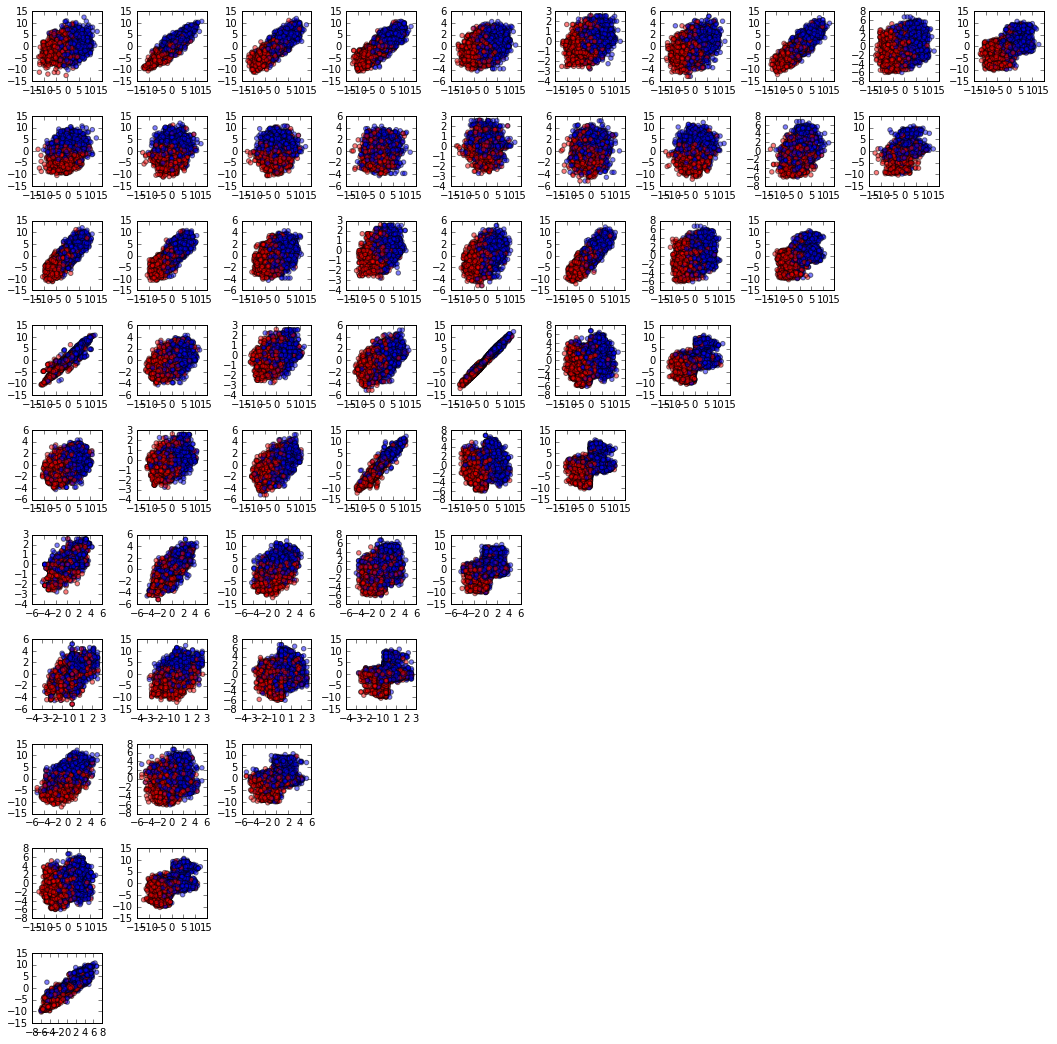

In [145]:
plot_combinatory_two_dim_data(train_data_transformed, train_labels)

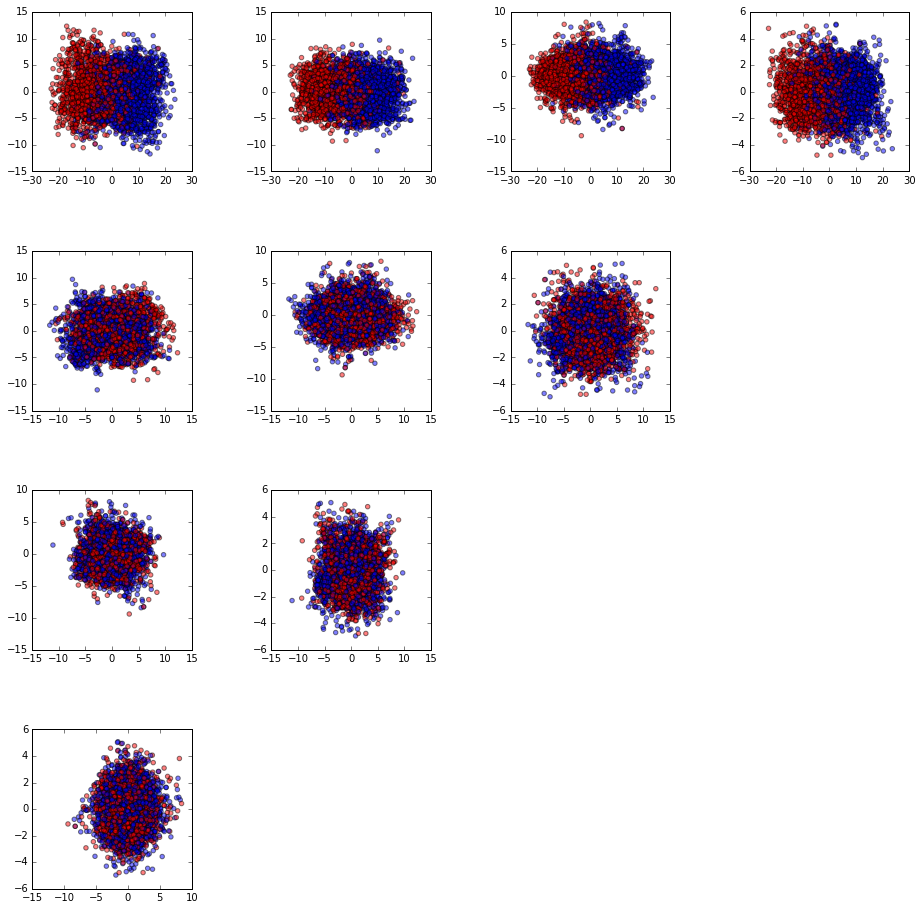

In [185]:
kernel_pca = KernelPCA(n_components=5, gamma=0.0001, kernel='rbf')
train_data_kernel_transform = kernel_pca.fit_transform(train_data_transformed)
plot_combinatory_two_dim_data(train_data_kernel_transform, train_labels)

In [144]:
kernel_lr = Pipeline([('kernel', KernelPCA()), ('lr', LogisticRegression(C=2.0))])
print "KernelPCA Logistic Regression:\n"
params = {'kernel__n_components': [5,10,20], 'kernel__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 5]}
lg_grid_cls = train_gridsearch_classifier(kernel_lr,
                                       params,
                                       train_data_transformed, train_labels)
report_score(lg_grid_cls, dev_data_transformed, dev_labels)
print "------------------------------------------\n"

KernelPCA Logistic Regression:

Parameters scores:
mean: 0.77198, std: 0.00570, params: {'kernel__n_components': 5, 'kernel__gamma': 0.0001}
mean: 0.77329, std: 0.00503, params: {'kernel__n_components': 10, 'kernel__gamma': 0.0001}
mean: 0.77242, std: 0.00521, params: {'kernel__n_components': 20, 'kernel__gamma': 0.0001}
mean: 0.77198, std: 0.00570, params: {'kernel__n_components': 5, 'kernel__gamma': 0.001}
mean: 0.77329, std: 0.00503, params: {'kernel__n_components': 10, 'kernel__gamma': 0.001}
mean: 0.77242, std: 0.00521, params: {'kernel__n_components': 20, 'kernel__gamma': 0.001}
mean: 0.77198, std: 0.00570, params: {'kernel__n_components': 5, 'kernel__gamma': 0.01}
mean: 0.77329, std: 0.00503, params: {'kernel__n_components': 10, 'kernel__gamma': 0.01}
mean: 0.77242, std: 0.00521, params: {'kernel__n_components': 20, 'kernel__gamma': 0.01}
mean: 0.77198, std: 0.00570, params: {'kernel__n_components': 5, 'kernel__gamma': 0.1}
mean: 0.77329, std: 0.00503, params: {'kernel__n_compon

In [200]:
kernel_lr = Pipeline([('kernel', KernelPCA(kernel='linear')), ('lr', LogisticRegression())])
print "KernelPCA Logistic Regression:\n"
params = {'kernel__kernel': ['linear', 'poly', 'rbf'],
          'kernel__n_components': [9, 10, 11],
          'kernel__gamma': [0.001],
          'lr__C': [0.1]}
lg_grid_cls = train_gridsearch_classifier(kernel_lr,
                                       params,
                                       train_data_transformed, train_labels)
report_score(lg_grid_cls, dev_data_transformed, dev_labels)
print "------------------------------------------\n"

KernelPCA Logistic Regression:

Parameters scores:
mean: 0.77307, std: 0.00777, params: {'kernel__kernel': 'linear', 'kernel__n_components': 9, 'kernel__gamma': 0.001, 'lr__C': 0.1}
mean: 0.77351, std: 0.00629, params: {'kernel__kernel': 'linear', 'kernel__n_components': 10, 'kernel__gamma': 0.001, 'lr__C': 0.1}
mean: 0.77198, std: 0.00508, params: {'kernel__kernel': 'linear', 'kernel__n_components': 11, 'kernel__gamma': 0.001, 'lr__C': 0.1}
mean: 0.76740, std: 0.00445, params: {'kernel__kernel': 'poly', 'kernel__n_components': 9, 'kernel__gamma': 0.001, 'lr__C': 0.1}
mean: 0.76740, std: 0.00445, params: {'kernel__kernel': 'poly', 'kernel__n_components': 10, 'kernel__gamma': 0.001, 'lr__C': 0.1}
mean: 0.76740, std: 0.00445, params: {'kernel__kernel': 'poly', 'kernel__n_components': 11, 'kernel__gamma': 0.001, 'lr__C': 0.1}
mean: 0.76696, std: 0.00473, params: {'kernel__kernel': 'rbf', 'kernel__n_components': 9, 'kernel__gamma': 0.001, 'lr__C': 0.1}
mean: 0.76740, std: 0.00465, params: 

In [198]:
kernel_lr = Pipeline([
        ('kernel', KernelPCA(n_components=10, kernel="linear", gamma=0.0001)),
        ('lr', LogisticRegression(C=0.1))])
kernel_lr.fit(X_transformed, Y)
pred_probs = kernel_lr.predict_proba(test_data_transformed)

generate_test_output(pred_probs)

# Logistic Regression

In [129]:
print "Logistic Regression:\n"
params = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
lg_grid_cls = train_gridsearch_classifier(LogisticRegression(),
                                       params,
                                       train_data_transformed, train_labels)
report_score(lg_grid_cls, dev_data_transformed, dev_labels)
print "------------------------------------------\n"

print "Logistic Regression Standardize:\n"
params = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
lg_grid_cls = train_gridsearch_classifier(LogisticRegression(),
                                       params,
                                       standardize_features(two_dim_train_data_transformed), train_labels)
report_score(lg_grid_cls, standardize_features(two_dim_dev_data_transformed), dev_labels)
print "------------------------------------------\n"

print "Logistic Regression PCA:\n"
params = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
lg_grid_cls = train_gridsearch_classifier(LogisticRegression(),
                                       params,
                                       two_dim_train_data_transformed, train_labels)
report_score(lg_grid_cls, two_dim_dev_data_transformed, dev_labels)
print "------------------------------------------\n"

Logistic Regression:

Parameters scores:
mean: 0.76696, std: 0.00776, params: {'C': 0.0001}
mean: 0.76915, std: 0.00792, params: {'C': 0.001}
mean: 0.77024, std: 0.00910, params: {'C': 0.01}
mean: 0.77198, std: 0.00508, params: {'C': 0.1}
mean: 0.77220, std: 0.00491, params: {'C': 0.5}
mean: 0.77220, std: 0.00491, params: {'C': 1.0}
mean: 0.77242, std: 0.00521, params: {'C': 2.0}
mean: 0.77242, std: 0.00521, params: {'C': 10.0}


Best param: {'C': 2.0}, accuracy: 0.747
------------------------------------------

Logistic Regression Standardize:

Parameters scores:
mean: 0.76784, std: 0.00829, params: {'C': 0.0001}
mean: 0.76718, std: 0.00802, params: {'C': 0.001}
mean: 0.76849, std: 0.00748, params: {'C': 0.01}
mean: 0.76827, std: 0.00769, params: {'C': 0.1}
mean: 0.76784, std: 0.00777, params: {'C': 0.5}
mean: 0.76784, std: 0.00777, params: {'C': 1.0}
mean: 0.76784, std: 0.00777, params: {'C': 2.0}
mean: 0.76784, std: 0.00777, params: {'C': 10.0}


Best param: {'C': 0.01}, accuracy: 0

In [137]:
lg = LogisticRegression(C=2.0)
lg.fit(X_transformed, Y)
pred_probs = lg.predict_proba(test_data_transformed)

generate_test_output(pred_probs)

# KNN

In [133]:
kn = KNeighborsClassifier(n_neighbors=200)
kn.fit(train_data_transformed, train_labels)
pred_labels = kn.predict(dev_data_transformed)
print kn.score(dev_data_transformed, dev_labels)

0.752453653217
[[ 0.085  0.915]
 [ 0.84   0.16 ]
 [ 0.58   0.42 ]
 ..., 
 [ 0.905  0.095]
 [ 0.63   0.37 ]
 [ 0.37   0.63 ]]


In [79]:
print "KNN:\n"
knn_grid_cls = train_gridsearch_classifier(KNeighborsClassifier(),
                                          {'n_neighbors': [1, 5, 10, 50, 100, 200, 250, 300]},
                                          train_data_transformed, train_labels)
report_score(knn_grid_cls, dev_data_transformed, dev_labels)
print "------------------------------------------\n"

KNN:

Parameters scores:
mean: 0.70762, std: 0.00172, params: {'n_neighbors': 1}
mean: 0.75104, std: 0.00682, params: {'n_neighbors': 5}
mean: 0.75235, std: 0.00673, params: {'n_neighbors': 10}
mean: 0.76806, std: 0.01079, params: {'n_neighbors': 50}
mean: 0.76784, std: 0.01355, params: {'n_neighbors': 100}
mean: 0.77089, std: 0.00922, params: {'n_neighbors': 200}
mean: 0.76958, std: 0.00962, params: {'n_neighbors': 250}
mean: 0.76631, std: 0.00755, params: {'n_neighbors': 300}


Best param: {'n_neighbors': 200}, accuracy: 0.752
------------------------------------------



In [140]:
kn = KNeighborsClassifier(n_neighbors=200)
kn.fit(X_transformed, Y)
pred_probs = kn.predict_proba(test_data_transformed)
generate_test_output(pred_probs)

## Analyzing Error Cases

In [172]:
def print_lg_coef(classifier, features):   
    print pd.Series(classifier.coef_[0], index=features)
    print classifier.intercept_

def print_data_features(data, features):
    print pd.Series(data, index=features)

def examine_results(classifier, dev_data, dev_labels, error=True):
    pred_labels = classifier.predict(dev_data)
    pred_probs = classifier.predict_proba(dev_data)
    c = 0
    for i, label in enumerate(pred_labels):
        if c >= 5:
            break
        condition = label != dev_labels[i] if error else label == dev_labels[i]
        if condition:
            print "index: %(i)s, true label: %(true_label)s, predicted label: %(pred_label)s (%(pred_prob)s), \nfeatures: %(features)s\nfeature_weights: %(feature_weights)s\n" % {
                'i': i,
                'true_label': dev_labels[i],
                'pred_label': label,
                'pred_prob': pred_probs[i],
                'features': dev_data[i],
                'feature_weights': dev_data[i] * classifier.coef_[0]
            }
            c += 1

def rolling_hash(data):
    base = 100
    res = 0
    for i in range(data.shape[0]):
        res += base ** i * data[i]
    return res

In [114]:
lg = LogisticRegression(C=2.0)
lg.fit(train_data_transformed, train_labels)

print lg.score(dev_data_transformed, dev_labels)
print_lg_coef(lg, features_transformed)
print
print "Examin Error:"
examine_results(lg, dev_data_transformed, dev_labels)

0.747001090513
d_follower_count       0.118519
d_following_count      0.009132
d_listed_count         0.211129
d_mentions_received   -0.275133
d_retweets_received    0.086308
d_mentions_sent        0.054915
d_retweets_sent        0.176073
d_posts               -0.068741
d_network_feature_1    0.365933
d_network_feature_2    0.171528
d_network_feature_3   -0.061814
dtype: float64
[ 0.05161363]

Examin Error:
index: 0, true label: 0.0, predicted label: 1.0 ([ 0.05593154  0.94406846]), 
features: [ 7.08356798  3.63033752  5.26280003  4.62015244  6.87855662  0.22993833
 -0.11746883  0.10835157  4.77396935 -2.11094909 -1.59762451]
feature_weights: [ 0.83953628  0.03315383  1.1111306  -1.271155    0.59367297  0.01262701
 -0.02068307 -0.00744825  1.74695495 -0.36208789  0.09875519]

index: 3, true label: 1.0, predicted label: 0.0 ([ 0.61882341  0.38117659]), 
features: [-2.34615055  5.8982283  -0.10109988 -3.06327609 -3.34758918 -1.08181835
 -0.52082354 -0.22365659 -2.95757953  2.93166358  2.

In [232]:
def generate_reference_features(data):
    reference_count = {}
    reference_feature_names = ['ref_A', 'ref_B']
    reference_features = np.ones((data.shape[0], 2))
    for d in data:
        key_A = hashlib.sha1(d[0:11]).hexdigest()
        key_B = hashlib.sha1(d[11:]).hexdigest()
        if key_A not in reference_count:
            reference_count[key_A] = 1
        else:
            reference_count[key_A] += 1
        if key_B not in reference_count:
            reference_count[key_B] = 1
        else:
            reference_count[key_B] += 1
    
    for i, d in enumerate(data):
        key_A = hashlib.sha1(d[0:11]).hexdigest()
        key_B = hashlib.sha1(d[11:]).hexdigest()
        reference_features[i,0] = reference_count[key_A]
        reference_features[i,1] = reference_count[key_B]
    return (reference_feature_names, reference_features)

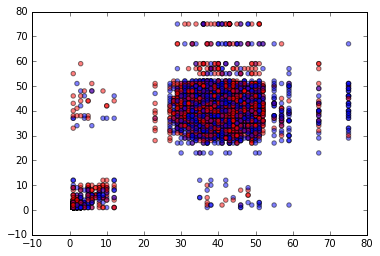

In [248]:
reference_features = generate_reference_features(X)
reference_features
plot_two_dim_data(reference_features[1], Y)

In [259]:
sum(reference_features[1][:,0] < 10)

659

(array([  648.,    41.,    11.,   241.,  1226.,  2118.,  1056.,    84.,
           37.,    38.]),
 array([  1. ,   8.4,  15.8,  23.2,  30.6,  38. ,  45.4,  52.8,  60.2,
         67.6,  75. ]),
 <a list of 10 Patch objects>)

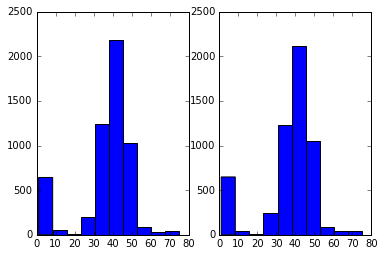

In [265]:
plt.subplot(1,2,1)
plt.hist(reference_features[1][:,0])
plt.subplot(1,2,2)
plt.hist(reference_features[1][:,1])